# Classifying Mobile User Activity 

## Import packages

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## Import data and check for missingness

In [2]:
# read in csv file
df = pd.read_csv("../data/user_behavior_dataset.csv")

In [3]:
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [20]:
df['User Behavior Class'].value_counts()

User Behavior Class
2    146
3    143
4    139
5    136
1    136
Name: count, dtype: int64

There are only 700 rows in the entire dataset, which means we have a small sample size to build a model from, but we can still split into a small train and test set and test out logistic regression and perhaps a tree-based model.

In [7]:
df.shape

(700, 11)

There is no missing data in the data set, which is rare and very easy to work with, as we won't have to worry about imputing missing values.

In [6]:
# check data for missingness
df.isna().sum()

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

In [14]:
# check datatypes
df.dtypes

User ID                         int64
Device Model                   object
Operating System               object
App Usage Time (min/day)        int64
Screen On Time (hours/day)    float64
Battery Drain (mAh/day)         int64
Number of Apps Installed        int64
Data Usage (MB/day)             int64
Age                             int64
Gender                         object
User Behavior Class             int64
dtype: object

In [60]:
# Split the dataframe into input variables vs target variable
X = df.iloc[ : , 1:-1].values
Y = df.iloc[ : , 10].values

In [61]:
X[ : , 0]

array(['Google Pixel 5', 'OnePlus 9', 'Xiaomi Mi 11', 'Google Pixel 5',
       'iPhone 12', 'Google Pixel 5', 'Samsung Galaxy S21', 'OnePlus 9',
       'Samsung Galaxy S21', 'iPhone 12', 'Google Pixel 5', 'OnePlus 9',
       'OnePlus 9', 'Xiaomi Mi 11', 'iPhone 12', 'Google Pixel 5',
       'OnePlus 9', 'iPhone 12', 'Google Pixel 5', 'iPhone 12',
       'Samsung Galaxy S21', 'OnePlus 9', 'Samsung Galaxy S21',
       'Google Pixel 5', 'OnePlus 9', 'Samsung Galaxy S21', 'iPhone 12',
       'Google Pixel 5', 'OnePlus 9', 'Samsung Galaxy S21',
       'Xiaomi Mi 11', 'Xiaomi Mi 11', 'Google Pixel 5', 'Google Pixel 5',
       'Xiaomi Mi 11', 'Samsung Galaxy S21', 'iPhone 12',
       'Samsung Galaxy S21', 'OnePlus 9', 'Samsung Galaxy S21',
       'Xiaomi Mi 11', 'OnePlus 9', 'Samsung Galaxy S21',
       'Samsung Galaxy S21', 'Xiaomi Mi 11', 'Xiaomi Mi 11', 'OnePlus 9',
       'Samsung Galaxy S21', 'Google Pixel 5', 'OnePlus 9',
       'Xiaomi Mi 11', 'Xiaomi Mi 11', 'Samsung Galaxy S21',
    

Dummy variables are created from the categorical variables, to be used in modeling.

In [62]:
# Creating a dummy variable
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [0, 1, 8])  # Apply OneHotEncoder to columns 0, 1, and 8
    ], 
    remainder='passthrough'  # Keep the rest of the columns as they are
)
X = column_transformer.fit_transform(X)

Preserve the column names of the data.

In [48]:
column_transformer.get_feature_names_out()

array(['onehot__x0_Google Pixel 5', 'onehot__x0_OnePlus 9',
       'onehot__x0_Samsung Galaxy S21', 'onehot__x0_Xiaomi Mi 11',
       'onehot__x0_iPhone 12', 'onehot__x1_Android', 'onehot__x1_iOS',
       'onehot__x8_Female', 'onehot__x8_Male', 'remainder__x2',
       'remainder__x3', 'remainder__x4', 'remainder__x5', 'remainder__x6',
       'remainder__x7'], dtype=object)

In [49]:
X.shape

(700, 15)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

I have a few hypotheses about the data we are using for modeling based on the exploratory data analysis, so I am going to run an initial exploratory logistic regression in order to test those theories.

The first hypothesis is that the Device Model variable is not going to have a big impact on predicting the User Behavior class, but the Operating System will have some impact. 

The second hypothesis is that age will not have a big impact on predicting the User Behavior class.

The third hypothesis is that since so many of the numeric variables are highly correlated with each other, also known as multicollinearity, the logistic regression model has difficulty determining which variable is driving the relationship with the outcome. As a result, the estimated coefficients (weights) can become highly sensitive to small changes in the data. This instability makes it hard to interpret the contribution of individual variables and can lead to unreliable coefficient estimates. This may be the biggest issue. We can test the multicollinearity by looking at the Variance Inflation Factor (VIF) when we build this inital model. If the VIF is in fact a problem, there are several things we can do do remediate it, such as removing some of the correlated features and only leaving one, PCA, or regularization.

Another thing to note here: I one-hot encoded the categorical variables, so that each value in the variable became it's own column. Techinically, when you use one-hot encoding with logistic regression (or any other linear models), it's often recommended to remove one of the encoded variables to avoid the problem of multicollinearity, which occurs when the independent variables are highly correlated with each other. This is known as the dummy variable trap. The model cannot uniquely estimate the relationship of each variable with the outcome because one variable is perfectly predictable from the others.

For this version of the model, I am leaving all of the dummy variables in the model, but I will remove one of the one-hot encoded columns for each variable in the next version.

In [51]:
# scale data to be the same scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [52]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

LogisticRegression()

In [53]:
y_pred = classifier.predict(X_test)

In [54]:
y_pred

array([4, 1, 1, 2, 3, 2, 2, 1, 4, 3, 1, 1, 2, 1, 3, 4, 5, 1, 3, 2, 5, 4,
       3, 4, 4, 2, 3, 5, 2, 5, 1, 3, 1, 3, 4, 5, 5, 1, 1, 2, 3, 4, 1, 3,
       2, 5, 3, 3, 1, 3, 2, 2, 2, 1, 5, 5, 3, 1, 4, 2, 3, 2, 1, 2, 5, 2,
       5, 1, 5, 5, 1, 2, 3, 2, 3, 2, 5, 4, 4, 4, 2, 1, 4, 3, 4, 4, 5, 3,
       3, 1, 1, 4, 2, 3, 4, 2, 2, 1, 3, 5, 3, 3, 1, 1, 3, 4, 5, 1, 4, 4,
       5, 4, 4, 3, 3, 2, 4, 3, 4, 3, 3, 4, 5, 4, 5, 2, 3, 5, 4, 5, 3, 2,
       1, 3, 2, 3, 5, 2, 1, 2])

In [55]:
cm = confusion_matrix(Y_test, y_pred, labels = [1, 2, 3, 4, 5])

In [56]:
cm

array([[27,  0,  0,  0,  0],
       [ 0, 29,  0,  0,  0],
       [ 0,  0, 34,  0,  0],
       [ 0,  0,  0, 27,  0],
       [ 0,  0,  0,  0, 23]])

<Axes: >

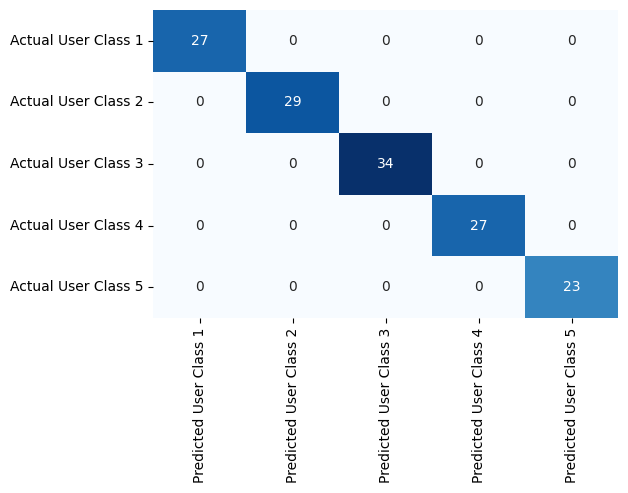

In [57]:
# Create a confusion matrix heatmap with labels using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted User Class 1', 'Predicted User Class 2', 'Predicted User Class 3', 'Predicted User Class 4', 'Predicted User Class 5'], 
            yticklabels=['Actual User Class 1', 'Actual User Class 2', 'Actual User Class 3', 'Actual User Class 4', 'Actual User Class 5'])

Overall, we were able to perfectly fit a logistic regression model to the User Behavior Classes. To me, this indicates a few possibilities:

1. Variables like Screen On Time are so highly correlated with the User Behavior Class that this input variable basically gives away the answer as to a user's behavior class. In the EDA notebook, we saw that a boxplot of screen time almost perfectly breaks the users into user behavior classes by Screen On Time. This variable, plus some of the other numeric variables lead directly to the answer.

2. Our model is likely overfit due to a large number of inputs and a small sample size.

## Feature Reduction

The model seems to predict user behavior class well, but for the sake of using less resources in deployment and avoiding overfitting, we can reduce the number of model inputs and still have a decent model.

We will use gender, operating system, and screen time, since all of these features had a relationship with User Behavior class, and we want to avoid multicollinearity, therefore leaving out the other highly correlated numeric variables.

In [64]:
X = X[:,[5,7,10]]
X

array([[1.0, 0.0, 6.4],
       [1.0, 1.0, 4.7],
       [1.0, 0.0, 4.0],
       ...,
       [1.0, 1.0, 3.1],
       [1.0, 0.0, 1.7],
       [1.0, 1.0, 5.4]], dtype=object)

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=66)

In [66]:
# scale data to be the same scale
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [67]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

LogisticRegression()

In [68]:
y_pred = classifier.predict(X_test)

In [69]:
cm = confusion_matrix(Y_test, y_pred, labels = [1, 2, 3, 4, 5])

This model does not perform as well as the previous model that had issues with multicollinearity and over-fitting. I am going to swap around some of the variables to see if I can get better performance.

<Axes: >

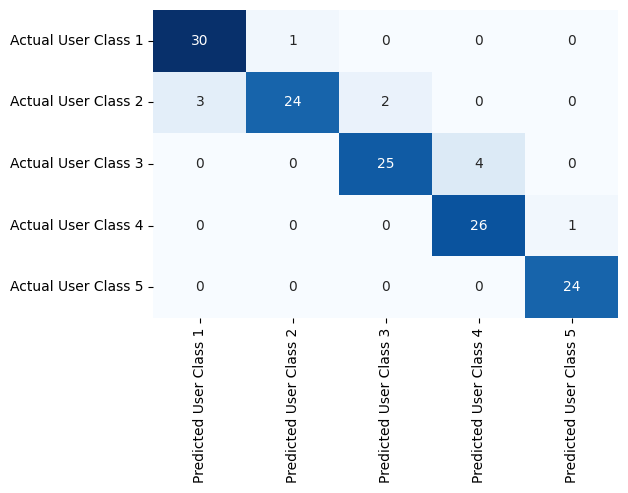

In [70]:
# Create a confusion matrix heatmap with labels using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted User Class 1', 'Predicted User Class 2', 'Predicted User Class 3', 'Predicted User Class 4', 'Predicted User Class 5'], 
            yticklabels=['Actual User Class 1', 'Actual User Class 2', 'Actual User Class 3', 'Actual User Class 4', 'Actual User Class 5'])